In [203]:
import numpy as np
import matplotlib.pyplot as plt


# Monte-Carlo simulation of atom re-arrangement: Simplified version

### Description

This simulation aims to calculate the porbability of generating an ordered array of atoms under various sources of loss.

The simulation works as follow: 
1. Load the NxN array with a single site loading probability
2. Image the array. This process will add single atom image losses 
3. Apply the vacuum loss associated to the imaging time
4. Re-arrange atoms. For now this is very simple. In this case I assume a re-arrangement success probability per single atom and I apply it to each trap site. So if the P_success = 99%, then if one trap had an atom before it will remain with 99% probability, and if the trap  was initially empty it will be filled with 99% probability. In a realistic re-arrangement scheme pretty much every atom will move around so I think it is a good enough model.
5. Apply the loss associated to the total re-arrangement time
6. Apply second image
7. Apply the vacuum loss associated to the second imaging time

We then look at the probability of obtaining a defect-free array.


*Loss sources*:

- **P_loading**:  Loading probability of a single atom in a tweezer. For standard methods it is on average 0.5-0.6 but can be larger for grey molasses
- **P_img_loss**: Probability of loosing a single atom during an image
- **P_arrangement_loss**:  Average probability of loosing an atom during re-arrangement. This is per atom in the array, meaning that if I have 100 atoms as a target array size, I will have 100-P_arrangement_loss atoms at the end of the re-arrangement procedure

***

*Times* in seconds

- **t_img**: image time 
- **t_arrangement**: time it takes to do the full re-arrangement procedure
- **tau_vac**: vacuum lifetime.
                     

## Static Parameters

In [161]:
""" Relevant probabilities to tune """
P_loading = 0.6 
P_img_loss = 0*1e-3
P_arrangement_loss = 0

In [162]:
""" Relevant timings """
t_img = 25e-3
t_arrangement = 100e-3
tau_vac = 3000

In [2]:
n_rows = 5 # number of rows for the target array
n_col = 5 # number of columns for the target array

## Functions

In [185]:
def load_array(P_load, rows =n_rows, cols= n_col ):
    """ 1) generate a 2D array of random numbers in [0,1] 
    2) then compares if those numbers are below P_load. Turns the array in True/False array. 
    3) the multiplication by 1 turns the array back into a 2D array of 0s and 1s"""
    return (np.random.random((rows,cols)) < P_load) *1

def apply_img_loss(twz_array, P_loss, rows =n_rows, cols= n_col, debug= False):
    """ 
    if loaded_atom & survive_img -> atom
    """
    img_surv= (np.random.random((rows, cols)) > P_loss) *1
    if (debug):
        print(img_surv)
    return np.logical_and(twz_array, img_surv)*1

def arrange_atoms(twz_array,P_arr_loss, rows =n_rows, cols= n_col, debug= False):
    """ We want the following truth table: (atom loaded, re_arrangement success) -> out
    (0,0) -> 0
    (0,1) -> 1
    (1,0) -> 0
    (1,1) -> 1 
    """
    rearr_succ= (np.random.random((rows,cols)) > P_arr_loss) *1 # table with re-arrangement success
    if (debug):
        print(rearr_succ)
    rearr_fail= 1- rearr_succ # the same but where it fails
    # first we fill the trap that were empty and were successfuly filled
    fill_empty= twz_array+rearr_succ # this turns (0,1) -> 1 and (1, 1) -> 2, the rest remains intact
    fill_empty[fill_empty==2]=1 # this turns the 2s into 1s
    # now we remove the atoms that were originally loaded but for which the re-arrangement failed
    arr_out= (fill_empty - rearr_fail) # this turns (atom loaded, re_arrangement success): (1,0)-> 0, and (0,0) -> -1
    arr_out[arr_out==-1]=0 # removes the -1
    return arr_out

def apply_vaccum_loss(twz_array, op_time, vac_lifetime, rows =n_rows, cols= n_col, debug= False ):
    """ op_time: time of the desired operation. Can be imaging, or re-arrangement """
    P_vac_loss = 1 - np.exp (- op_time/vac_lifetime)
    vac_surv= (np.random.random((rows, cols)) > P_vac_loss) *1
    if (debug):
        print(vac_surv)
    return np.logical_and(twz_array, vac_surv)*1


## Simulation with static parameters

In [186]:
n_traj = 100
tot_atoms =np.zeros(n_traj)
for i in range(n_traj):
    twz_array = load_array(P_loading)
    twz_array = apply_img_loss(twz_array, P_img_loss)
    twz_array = apply_vaccum_loss(twz_array, t_img, tau_vac)
    twz_array = arrange_atoms(twz_array, P_arrangement_loss)
    twz_array = apply_vaccum_loss(twz_array, t_arrangement, tau_vac)
    twz_array = apply_img_loss(twz_array, P_img_loss)
    twz_array = apply_vaccum_loss(twz_array, t_img, tau_vac)
    tot_atoms[i]= twz_array.sum()

avg_atoms= tot_atoms.mean()
avg_atoms

25.0

## Simulation: scan parameters

In [395]:
def run_simulation(param_dict):
    n_traj = param_dict['traj']
    tot_atoms =np.zeros(n_traj)
    full_filling =np.zeros(n_traj)
    # twz_arrays()
    rows = param_dict['n_rows']
    if param_dict['cols=rows']:
        cols=rows
    else:
        cols = param_dict['n_cols']
    
    for i in range(n_traj):
        twz_array = load_array(param_dict['P_loading'], rows= rows, cols = cols)
        twz_array = apply_img_loss(twz_array, param_dict['P_img_loss'], rows= rows, cols = cols)
        twz_array = apply_vaccum_loss(twz_array, param_dict['t_img'], param_dict['tau_vac'], rows= rows, cols = cols)
        twz_array = arrange_atoms(twz_array, param_dict['P_arrangement_loss'], rows= rows, cols = cols)
        twz_array = apply_vaccum_loss(twz_array, param_dict['t_arrangement'], param_dict['tau_vac'], rows= rows, cols = cols)
        twz_array = apply_img_loss(twz_array, param_dict['P_img_loss'], rows= rows, cols = cols)
        twz_array = apply_vaccum_loss(twz_array, param_dict['t_img'], param_dict['tau_vac'], rows= rows, cols = cols)
        
        tot_atoms[i]= twz_array.sum()
        if tot_atoms[i] == rows * cols:
            full_filling[i] =1
        # twz_arrays.append(twz_array)
    avg_atoms= tot_atoms.mean()
    p_full_filling= full_filling.mean()
    return avg_atoms, p_full_filling

In [296]:
params = {}
params['P_loading']= 0.6 
params['P_img_loss'] = 0
params['P_arrangement_loss'] = 0
params['t_img'] = 15e-3
params['t_arrangement'] = 100e-3
params['tau_vac'] = 2800
params['n_rows'] = 10
params['n_cols'] = 10
params['cols=rows'] =True
params['traj'] = 1000


### scan imaging loss

In [306]:
img_loss= np.linspace(0,1e-2)
P_filling = np.zeros(len(img_loss))
P_full_filling = np.zeros(len(img_loss))

img_loss_orig = params['P_img_loss']

for i in range(len(img_loss)):
    params['P_img_loss'] = img_loss[i]
    n_atoms= params['n_rows']**2
    result= run_simulation(params)
    P_filling[i]= result[0]/(n_atoms) 
    P_full_filling[i] = result[1]

params['P_img_loss']= img_loss_orig # reset img loss


Text(0.5, 1.0, '10x10 array, 2800s vac lifetime, no re-arrangement loss')

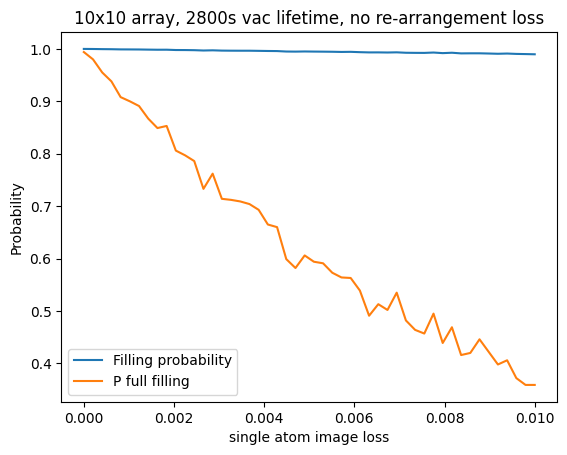

In [310]:
fig,ax = plt.subplots()
ax.plot(img_loss, P_filling, label= 'Filling probability' )
ax.plot(img_loss, P_full_filling, label= 'P full filling')
ax.set_xlabel( "single atom image loss")
ax.set_ylabel("Probability")
ax.legend()
ax.set_title("10x10 array, 2800s vac lifetime, no re-arrangement loss")

### scan: vacuum lifetime

In [353]:
vac_taus= np.linspace(50,3000)
P_filling = np.zeros(len(vac_taus))
P_full_filling = np.zeros(len(img_loss))

vac_tau_orig = params['tau_vac']

for i in range(len(img_loss)):
    params['tau_vac'] = vac_taus[i]
    n_atoms= params['n_rows']**2
    result= run_simulation(params)
    P_filling[i]= result[0]/(n_atoms) 
    P_full_filling[i] = result[1]
    
params['tau_vac']= vac_tau_orig # reset img loss

Text(0.5, 1.0, '10x10 array, no img-loss, no re-arrangement loss')

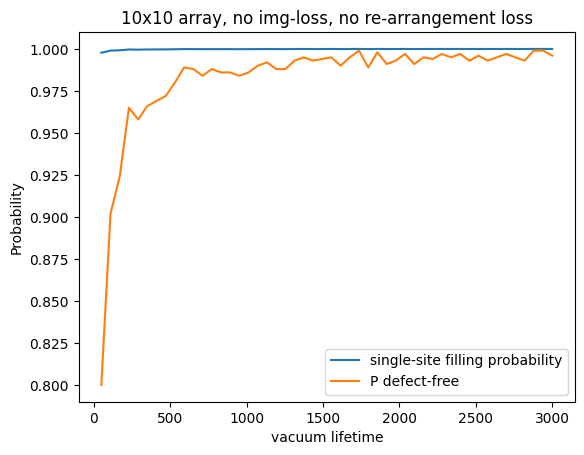

In [355]:
fig,ax = plt.subplots()
ax.plot(vac_taus, P_filling, label= 'single-site filling probability' )
ax.plot(vac_taus, P_full_filling, label= 'P defect-free')
ax.set_xlabel( "vacuum lifetime")
ax.set_ylabel("Probability")
ax.legend()
ax.set_title("10x10 array, no img-loss, no re-arrangement loss")

In [356]:
vac_taus= np.linspace(50,3000)
n_rows= np.arange(5, 30)

P_filling = np.zeros((len(vac_taus),len(n_rows)) )
P_full_filling = np.zeros((len(vac_taus),len(n_rows)))

vac_tau_orig = params['tau_vac']
n_rows_orig = params['n_rows']

for i in range(len(vac_taus)):
    for j in range(len(n_rows)):
        params['tau_vac'] = vac_taus[i]
        params['n_rows'] = n_rows[j]
        n_atoms= n_rows[j]**2
        
        result= run_simulation(params)
        P_filling[i,j]= result[0]/(n_atoms) 
        P_full_filling[i,j] = result[1]

params['tau_vac']= vac_tau_orig # reset img loss
params['n_rows']= n_rows_orig # reset n_rows

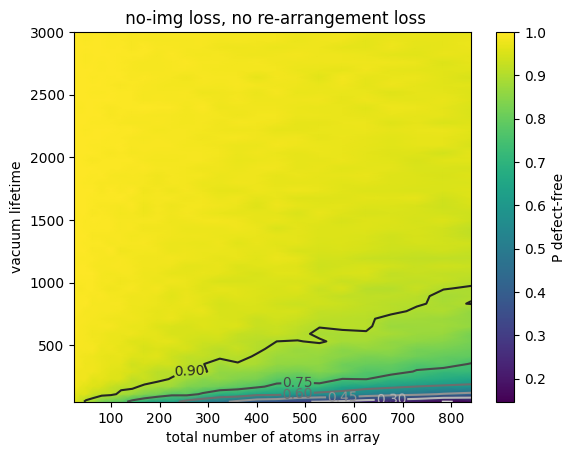

In [359]:
fig,ax = plt.subplots()
im= ax.pcolormesh(n_rows**2,vac_taus, P_full_filling, shading='gouraud')
ax.set_xlabel("total number of atoms in array")
ax.set_ylabel("vacuum lifetime")
ax.set_title(" no-img loss, no re-arrangement loss")
CS= ax.contour(n_rows**2,vac_taus, P_full_filling, cmap='binary') #cmap=plt.cm.YlGn)
ax.clabel(CS, fontsize=10)
fig.colorbar(im, ax=ax, label='P defect-free')

### 2D scan: fixed lifetime,no rearrangement loss, vary array size and img loss

In [384]:
img_loss= np.linspace(0,2e-3)
n_rows= np.arange(5, 30)

P_filling = np.zeros((len(img_loss),len(n_rows)) )
P_full_filling = np.zeros((len(img_loss),len(n_rows)))

img_loss_orig = params['P_img_loss']
n_rows_orig = params['n_rows']

for i in range(len(img_loss)):
    for j in range(len(n_rows)):
        params['P_img_loss'] = img_loss[i]
        params['n_rows'] = n_rows[j]
        n_atoms= n_rows[j]**2
        
        result= run_simulation(params)
        P_filling[i,j]= result[0]/(n_atoms) 
        P_full_filling[i,j] = result[1]

params['P_img_loss']= img_loss_orig # reset img loss
params['n_rows']= n_rows_orig # reset n_rows

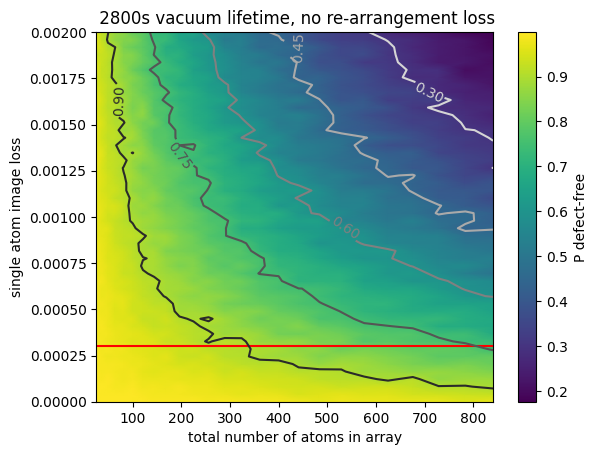

In [387]:
fig,ax = plt.subplots()
im= ax.pcolormesh(n_rows**2,img_loss, P_full_filling, shading='gouraud')
ax.set_xlabel("total number of atoms in array")
ax.set_ylabel("single atom image loss")
ax.set_title(" 2800s vacuum lifetime, no re-arrangement loss")
ax.axhline(y=3e-4, color='r', linestyle='-')
CS= ax.contour(n_rows**2,img_loss, P_full_filling, cmap='binary') #cmap=plt.cm.YlGn)
ax.clabel(CS, fontsize=10)
fig.colorbar(im, ax=ax, label='P defect-free')


### 2D scan: fixed lifetime, fixed rearrangement loss, vary array size and img loss

In [388]:
img_loss= np.linspace(0,2e-3)
n_rows= np.arange(5, 30)

P_filling = np.zeros((len(img_loss),len(n_rows)) )
P_full_filling = np.zeros((len(img_loss),len(n_rows)))

img_loss_orig = params['P_img_loss']
n_rows_orig = params['n_rows']
rearr_loss_orig = params['P_arrangement_loss']
params['P_arrangement_loss']= 0.003

for i in range(len(img_loss)):
    for j in range(len(n_rows)):
        params['P_img_loss'] = img_loss[i]
        params['n_rows'] = n_rows[j]
        n_atoms= n_rows[j]**2
        
        result= run_simulation(params)
        P_filling[i,j]= result[0]/(n_atoms) 
        P_full_filling[i,j] = result[1]

params['P_img_loss']= img_loss_orig # reset img loss
params['n_rows']= n_rows_orig # reset n_rows
params['P_arrangement_loss']= rearr_loss_orig


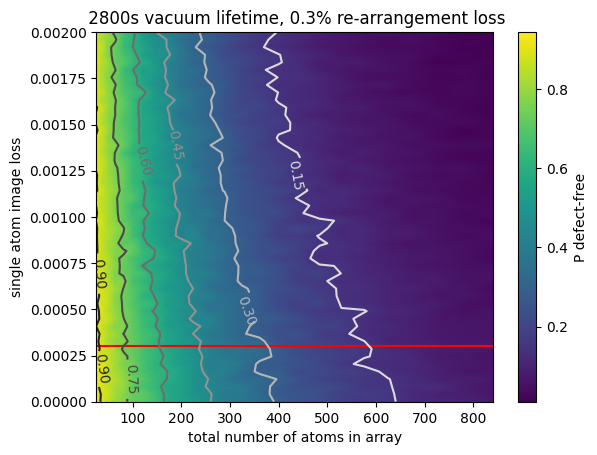

In [389]:
fig,ax = plt.subplots()
im= ax.pcolormesh(n_rows**2,img_loss, P_full_filling, shading='gouraud')
ax.set_xlabel("total number of atoms in array")
ax.set_ylabel("single atom image loss")
ax.set_title(" 2800s vacuum lifetime, 0.3% re-arrangement loss")
ax.axhline(y=3e-4, color='r', linestyle='-')
CS= ax.contour(n_rows**2,img_loss, P_full_filling, cmap='binary') #cmap=plt.cm.YlGn)
ax.clabel(CS, fontsize=10)
fig.colorbar(im, ax=ax, label='P defect-free')


### 2D scan: fixed lifetime, vary array size and re-arrangement loss. No img loss

In [365]:
rearr_loss= np.linspace(0,1e-2)
n_rows= np.arange(5, 30)

P_filling = np.zeros((len(rearr_loss),len(n_rows)) )
P_full_filling = np.zeros((len(rearr_loss),len(n_rows)))

rearr_loss_orig = params['P_arrangement_loss']
n_rows_orig = params['n_rows']

for i in range(len(rearr_loss)):
    for j in range(len(n_rows)):
        params['P_arrangement_loss'] = rearr_loss[i]
        params['n_rows'] = n_rows[j]
        n_atoms= n_rows[j]**2
        
        result= run_simulation(params)
        P_filling[i,j]= result[0]/(n_atoms) 
        P_full_filling[i,j] = result[1]

params['P_arrangement_loss']= rearr_loss_orig # reset img loss
params['n_rows']= n_rows_orig # reset n_rows

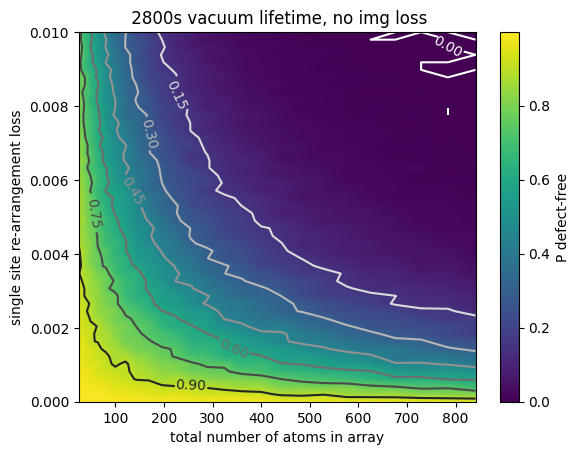

In [366]:
fig,ax = plt.subplots()
im= ax.pcolormesh(n_rows**2,rearr_loss, P_full_filling, shading='gouraud')
ax.set_xlabel("total number of atoms in array")
ax.set_ylabel("single site re-arrangement loss")
ax.set_title(" 2800s vacuum lifetime, no img loss")
CS= ax.contour(n_rows**2,rearr_loss, P_full_filling, cmap='binary') #cmap=plt.cm.YlGn)
ax.clabel(CS, fontsize=10)
fig.colorbar(im, ax=ax,label='P defect-free')


### 2D scan: fixed lifetime, fixed img loss. Vary array size and re-arrangement loss. 

In [382]:
rearr_loss= np.linspace(0,1e-2)
n_rows= np.arange(5, 30)

P_filling = np.zeros((len(rearr_loss),len(n_rows)) )
P_full_filling = np.zeros((len(rearr_loss),len(n_rows)))

rearr_loss_orig = params['P_arrangement_loss']
n_rows_orig = params['n_rows']
img_loss_orig = params['P_img_loss']

params['P_img_loss'] = 0.03e-2


for i in range(len(rearr_loss)):
    for j in range(len(n_rows)):
        params['P_arrangement_loss'] = rearr_loss[i]
        params['n_rows'] = n_rows[j]
        n_atoms= n_rows[j]**2
        
        result= run_simulation(params)
        P_filling[i,j]= result[0]/(n_atoms) 
        P_full_filling[i,j] = result[1]

params['P_arrangement_loss']= rearr_loss_orig # reset img loss
params['n_rows']= n_rows_orig # reset n_rows
params['P_img_loss'] = img_loss_orig


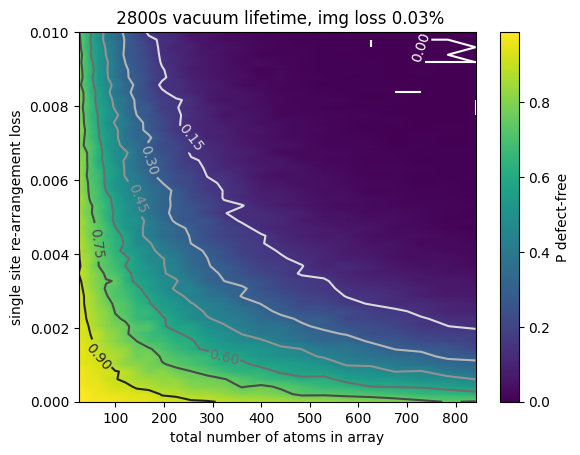

In [383]:
fig,ax = plt.subplots()
im= ax.pcolormesh(n_rows**2,rearr_loss, P_full_filling, shading='gouraud')
ax.set_xlabel("total number of atoms in array")
ax.set_ylabel("single site re-arrangement loss")
ax.set_title(" 2800s vacuum lifetime, img loss 0.03%")
CS= ax.contour(n_rows**2,rearr_loss, P_full_filling, cmap='binary') #cmap=plt.cm.YlGn)
ax.clabel(CS, fontsize=10)
fig.colorbar(im, ax=ax,label='P defect-free')

## Simulation: multiple rearrangement rounds

In [411]:
def extra_arrange_atoms(twz_array, P_arr_loss, rows =n_rows, cols= n_col, debug= False):
    """ In this case we only want to fill only the empty traps!
    """
    rearr_succ= (np.random.random((rows,cols)) > P_arr_loss) *1 # table with re-arrangement success
    if (debug):
        print(rearr_succ)
    empty_traps= 1-twz_array
    return twz_array + (rearr_succ*empty_traps)

In [418]:
def run_simulation_multiple_rearrange(param_dict):
    n_traj = param_dict['traj']
    tot_atoms =np.zeros(n_traj)
    full_filling =np.zeros(n_traj)
    # twz_arrays()
    rows = param_dict['n_rows']
    if param_dict['cols=rows']:
        cols=rows
    else:
        cols = param_dict['n_cols']
    
    for i in range(n_traj):
        twz_array = load_array(param_dict['P_loading'], rows= rows, cols = cols)
        twz_array = apply_img_loss(twz_array, param_dict['P_img_loss'], rows= rows, cols = cols)
        twz_array = apply_vaccum_loss(twz_array, param_dict['t_img'], param_dict['tau_vac'], rows= rows, cols = cols)
        twz_array = arrange_atoms(twz_array, param_dict['P_arrangement_loss'], rows= rows, cols = cols)
        twz_array = apply_vaccum_loss(twz_array, param_dict['t_arrangement'], param_dict['tau_vac'], rows= rows, cols = cols)
        twz_array = apply_img_loss(twz_array, param_dict['P_img_loss'], rows= rows, cols = cols)
        twz_array = apply_vaccum_loss(twz_array, param_dict['t_img'], param_dict['tau_vac'], rows= rows, cols = cols)
        
        for j in range(param_dict['extra_rearrangement_rounds']):
            twz_array = extra_arrange_atoms(twz_array, param_dict['P_extra_arrangement_loss'], rows= rows, cols = cols)
            twz_array = apply_vaccum_loss(twz_array, param_dict['t_arrangement'], param_dict['tau_vac'], rows= rows, cols = cols)
            twz_array = apply_img_loss(twz_array, param_dict['P_img_loss'], rows= rows, cols = cols)
            twz_array = apply_vaccum_loss(twz_array, param_dict['t_img'], param_dict['tau_vac'], rows= rows, cols = cols)
            
        tot_atoms[i]= twz_array.sum()
        if tot_atoms[i] == rows * cols:
            full_filling[i] =1
        # twz_arrays.append(twz_array)
    avg_atoms= tot_atoms.mean()
    p_full_filling= full_filling.mean()
    return avg_atoms, p_full_filling

In [419]:
params = {}
params['P_loading']= 0.6 
params['P_img_loss'] = 0
params['P_arrangement_loss'] = 0
params['t_img'] = 15e-3
params['t_arrangement'] = 100e-3
params['tau_vac'] = 2800
params['n_rows'] = 10
params['n_cols'] = 10
params['cols=rows'] =True
params['traj'] = 1000

params['extra_rearrangement_rounds']= 1
params['P_extra_arrangement_loss'] = 0

### 2D scan: fixed lifetime, fixed rearrangement loss, vary array size and img loss

In [420]:
img_loss= np.linspace(0,2e-3)
n_rows= np.arange(5, 30)

P_filling = np.zeros((len(img_loss),len(n_rows)) )
P_full_filling = np.zeros((len(img_loss),len(n_rows)))

img_loss_orig = params['P_img_loss']
n_rows_orig = params['n_rows']
rearr_loss_orig = params['P_arrangement_loss']
extra_rearr_loss_orig = params['P_extra_arrangement_loss']
params['P_arrangement_loss']= 0.003
params['P_extra_arrangement_loss'] = 0.003

for i in range(len(img_loss)):
    for j in range(len(n_rows)):
        params['P_img_loss'] = img_loss[i]
        params['n_rows'] = n_rows[j]
        n_atoms= n_rows[j]**2
        
        result= run_simulation_multiple_rearrange(params)
        P_filling[i,j]= result[0]/(n_atoms) 
        P_full_filling[i,j] = result[1]

params['P_img_loss']= img_loss_orig # reset img loss
params['n_rows']= n_rows_orig # reset n_rows
params['P_arrangement_loss']= rearr_loss_orig
params['P_extra_arrangement_loss']= extra_rearr_loss_orig


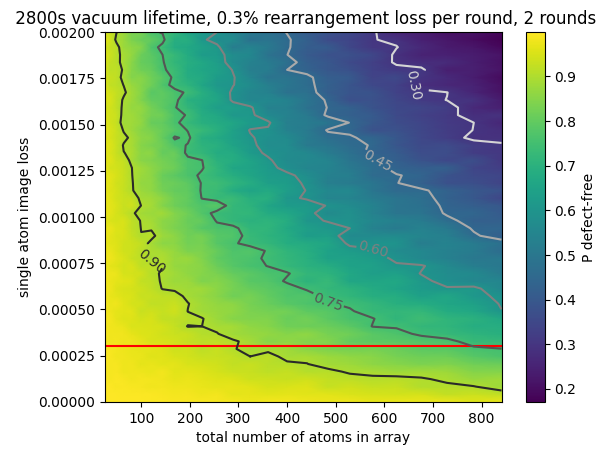

In [421]:
fig,ax = plt.subplots()
im= ax.pcolormesh(n_rows**2,img_loss, P_full_filling, shading='gouraud')
ax.set_xlabel("total number of atoms in array")
ax.set_ylabel("single atom image loss")
ax.set_title(" 2800s vacuum lifetime, 0.3% rearrangement loss per round, 2 rounds")
ax.axhline(y=3e-4, color='r', linestyle='-')
CS= ax.contour(n_rows**2,img_loss, P_full_filling, cmap='binary') #cmap=plt.cm.YlGn)
ax.clabel(CS, fontsize=10)
fig.colorbar(im, ax=ax, label='P defect-free')


# Random tests

In [407]:
twz= load_array(P_loading, 5,5)
print(twz)
extra_arrange_atoms(twz, 0.2, rows =5, cols= 5, debug= True)

[[0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 1 0]
 [0 0 1 0 0]
 [0 1 0 1 1]]
[[1 1 1 1 1]
 [1 1 0 1 1]
 [1 1 0 1 1]
 [0 1 1 1 1]
 [1 1 1 1 0]]


array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [367]:
1/4.5

0.2222222222222222

In [370]:
100-(99.5/(1-0.015/100))

0.48507276091413587

In [381]:
(1-0.985/(np.exp(-100e-3/10)*(1-0.002)))*100

0.3106799020134776

In [378]:
np.exp(-100e-3/10)

0.9900498337491681

In [379]:
(1-0.002)

0.995

In [424]:
125/0.65/0.9/0.082

2605.7952887221177